In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import time


$$\textbf{\Large Binomial Tree Model}$$

In [17]:
def Binominal_tree(S0, K, T, r, n, sigma, option_type_1,option_type_2):
    #Khởi tạo tham số
    h = T/n #Số bước thời gian
    u = np.exp(r*h+sigma*np.sqrt(h)) #Hệ số tăng
    d = np.exp(r*h-sigma*np.sqrt(h)) #Hệ số tăng
    p = (np.exp(r*h)-d)/(u-d) #Lãi suất phi rủi ro
    
    #Stock_price
    stock_price = np.zeros((n+1,n+1))
    for i in range(n+1):
        for j in range(i+1):
            stock_price[j,i] = S0*(u**(i-j))*(d**j)

    #Giá quyền chọn tại đáo hạn
    option_price = np.zeros((n+1,n+1))
    if option_type_1 == 'Call':
        option_price[:,n] = np.maximum(stock_price[:,n] - K,0)
    elif option_type_1 == 'Put':
        option_price[:,n] = np.maximum(K-stock_price[:,n],0)

    #Bakward induction
    #Europe
    if option_type_2 == 'Europe':
        for i in range(n-1,-1,-1):
            for j in range(i+1):
                option_price[j,i] = np.exp(-r*h)*(p*option_price[j,i+1]+(1-p)*option_price[j+1,i+1])

    #American
    if option_type_2 == 'American':
        for i in range(n-1, -1, -1):
            for j in range(i+1):
                continuation_value = np.exp(-r*h) * (p * option_price[j, i+1] + (1-p) * option_price[j+1, i+1])
                exercise_value = np.maximum(stock_price[j, i] - K, 0) if option_type_1 == 'Call' else np.maximum(K - stock_price[j, i], 0)
                option_price[j, i] = np.maximum(continuation_value, exercise_value)
   
    return option_price[0,0]

$$\textbf{\Large Black-Scholes}$$


In [18]:
def BS(S, K, T, r, sigma, type):   
    N = norm.cdf
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if type == 'call':
        return S * N(d1) - K * np.exp(-r * T) * N(d2)    
    if type == 'put':
        return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

$$\textbf{\Large Monte Carlo Method for Option Pricing}$$
**1. Basic Monte Carlo**

**2. Monte Carlo Arithmetic Variates**

**3. Monte Carlo Control Variates**

**4. Monte Carlo combined Arithmetic Variates with Control Variates**

In [19]:
def monte_carlo(S0, r, sigma, T, Nsteps, Nstock):    
    # Khởi tạo
    dt = T / Nsteps
    S = np.zeros((Nstock, Nsteps + 1))
    S[:, 0] = S0
    
    # Tạo ma trận Z ngẫu nhiên
    Z = np.random.normal(size=(Nstock, Nsteps))
    
    # Vector hóa tính toán đường đi giá cổ phiếu
    drift = (r - 0.5 * sigma ** 2) * dt
    vol = sigma * np.sqrt(dt)
    for j in range(Nsteps):
        S[:, j + 1] = S[:, j] * np.exp(drift + vol * Z[:, j])
    
    return S

#Basic Monte Carlo
def monte_carlo_option(S0, K, r, T, Nsteps, sigma, Nstock, option_type='call'):
    # Mô phỏng đường đi giá cổ phiếu
    ST = monte_carlo(S0, r, sigma, T, Nsteps, Nstock)
    
    # Tính payoff
    if option_type == 'call':
        payoff = np.maximum(ST[:, -1] - K, 0)
    else:  # put
        payoff = np.maximum(K - ST[:, -1], 0)
    
    # Giá quyền chọn và độ lệch chuẩn
    discount = np.exp(-r * T)
    price = np.mean(payoff) * discount
    std = np.std(payoff) * discount / np.sqrt(Nstock)
    
    return price, std

#Monte Carlo Arithmetic
def monte_carlo_option_av(S0, K, r, sigma, T, Nsteps, Nstock, option_type='call'):
     # Khởi tạo
    Nsim = Nstock // 2
    dt = T / Nsteps
    discount = np.exp(-r * T)
    
    # Tạo ma trận Z ngẫu nhiên
    Z = np.random.normal(size=(Nsim, Nsteps))
    
    # Tính toán đường đi giá cổ phiếu
    drift = (r - 0.5 * sigma ** 2) * dt
    vol = sigma * np.sqrt(dt)
    STu = np.zeros((Nsim, Nsteps + 1))
    STd = np.zeros((Nsim, Nsteps + 1))
    STu[:, 0] = STd[:, 0] = S0
    
    # Vector hóa tính toán
    for j in range(Nsteps):
        STu[:, j + 1] = STu[:, j] * np.exp(drift + vol * Z[:, j])
        STd[:, j + 1] = STd[:, j] * np.exp(drift - vol * Z[:, j])
    
    # Tính payoff
    if option_type == 'call':
        Cu = np.maximum(STu[:, -1] - K, 0)
        Cd = np.maximum(STd[:, -1] - K, 0)
    else:  # put
        Cu = np.maximum(K - STu[:, -1], 0)
        Cd = np.maximum(K - STd[:, -1], 0)
    
    # Giá quyền chọn và độ lệch chuẩn
    price = np.mean((Cu + Cd) / 2) * discount
    std = np.std((Cu + Cd) / 2) * discount / np.sqrt(Nstock)
    
    return price, std


def monte_carlo_option_cv(S0, K, r, sigma, T, Nsteps, Nstock, option_type='call'):
    """Định giá quyền chọn với Monte Carlo và Control Variates"""
    
    # Mô phỏng đường đi giá cổ phiếu
    ST = monte_carlo(S0, r, sigma, T, Nsteps, Nstock)
    
    # Tính payoff
    if option_type == 'call':
        payoff = np.maximum(ST[:, -1] - K, 0)
    else:  # put
        payoff = np.maximum(K - ST[:, -1], 0)
    
    # Control variate: S_T
    X = ST[:, -1]  # Giá cổ phiếu tại T
    E_X = S0 * np.exp(r * T)  # Kỳ vọng của S_T
    
    # Ước lượng beta
    cov = np.cov(payoff, X)[0, 1]
    var_X = np.var(X)
    beta = cov / var_X if var_X != 0 else 0
    
    # Điều chỉnh payoff với control variate
    adjusted_payoff = payoff - beta * (X - E_X)
    
    # Giá quyền chọn và độ lệch chuẩn
    discount = np.exp(-r * T)
    price = np.mean(adjusted_payoff) * discount
    std = np.std(adjusted_payoff) * discount / np.sqrt(Nstock)
    
    return price, std    

def monte_carlo_option_av_cv(S0, K, r, sigma, T, Nsteps, Nstock, option_type='call'):   
    Nsim = Nstock // 2
    dt = T / Nsteps
    discount = np.exp(-r * T)
    
    # Tạo ma trận Z ngẫu nhiên
    Z = np.random.normal(size=(Nsim, Nsteps))
    
    # Tính toán đường đi giá cổ phiếu
    drift = (r - 0.5 * sigma ** 2) * dt
    vol = sigma * np.sqrt(dt)
    STu = np.zeros((Nsim, Nsteps + 1))
    STd = np.zeros((Nsim, Nsteps + 1))
    STu[:, 0] = STd[:, 0] = S0
    
    # Vector hóa tính toán
    for j in range(Nsteps):
        STu[:, j + 1] = STu[:, j] * np.exp(drift + vol * Z[:, j])
        STd[:, j + 1] = STd[:, j] * np.exp(drift - vol * Z[:, j])
    
    if option_type == 'call':
        payoff_u = np.maximum(STu[:, -1] - K, 0)
        payoff_d = np.maximum(STd[:, -1] - K, 0)
    else:
        payoff_u = np.maximum(K - STu[:, -1], 0)
        payoff_d = np.maximum(K - STd[:, -1], 0)
    
    payoff_av = (payoff_u + payoff_d) / 2
    
    X = (STu[:, -1] + STd[:, -1]) / 2
    E_X = S0 * np.exp(r * T)
    
    cov = np.cov(payoff_av, X)[0, 1]
    var_X = np.var(X)
    beta = -cov / var_X if var_X != 0 else 0
    
    adjusted_payoff = payoff_av + beta * (X - E_X)
    
    discount = np.exp(-r * T)
    price = np.mean(adjusted_payoff) * discount
    std = np.std(adjusted_payoff) * discount / np.sqrt(Nstock)
    
    return price, std





$$\textbf{\Large Finite Difference Method for Option Pricing}$$
**1. Explicit Method**

**2. Implicit Method**

**3. Crank-Nilson Method**

In [20]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.linalg import lu_factor, lu_solve
from scipy.interpolate import interp1d

def BS_FDM(S0, K, r, T, sigma, ds, dt, fdm_method, option_type):
    # Grid setup
    smax = 2 * max(S0, K) * np.exp(r * T)
    M = int(np.round(smax / ds)) #Số bước giá
    N = int(np.round(T / dt)) #Số bước thời gian
    S = np.linspace(0, smax, M + 1) #Lưu giá trị quyền chọn
    mesh = np.zeros((M + 1, N + 1))
    # Indices
    j = np.arange(M + 1)
    i = np.arange(N + 1)
    
    # Set boundary conditions
    if option_type == 'CALL':
        mesh[:, N] = np.maximum(S - K, 0)
        mesh[0, :] = 0
        mesh[M, :] = (smax - K) * np.exp(-r * dt * (N - i))
    elif option_type == 'PUT':
        mesh[:, N] = np.maximum(K - S, 0)
        mesh[0, :] = K * np.exp(-r * dt * (N - i))
        mesh[M, :] = 0
    
    # Finite difference methods
    if fdm_method == 'CRANK':
        a = (dt / 4) * (sigma**2 * j**2 - r * j)
        b = -(dt / 2) * (sigma**2 * j**2 + r)
        c = (dt / 4) * (sigma**2 * j**2 + r * j)
        
        # Construct matrices
        C = diags([-a[2:M], 1-b[1:M], -c[1:M-1]], [-1, 0, 1]).toarray()
        D = diags([a[2:M], 1+b[1:M], c[1:M-1]], [-1, 0, 1]).toarray()
        
        # LU decomposition
        lu, piv = lu_factor(C)
        
        for i in range(N-1, -1, -1):
            lost_val = np.zeros(M-1)
            lost_val[0] = a[1] * (mesh[0, i] + mesh[0, i+1])
            lost_val[-1] = c[M-1] * (mesh[M, i] + mesh[M, i+1])
            rhs = D @ mesh[1:M, i+1] + lost_val
            mesh[1:M, i] = lu_solve((lu, piv), rhs)
    
    elif fdm_method == 'IMPLICIT':
        a = 0.5 * (r * dt * j - sigma**2 * dt * j**2)
        b = 1 + sigma**2 * dt * j**2 + r * dt
        c = -0.5 * (r * dt * j + sigma**2 * dt * j**2)
        
        # Construct matrix
        B = diags([a[2:M], b[1:M], c[1:M-1]], [-1, 0, 1]).toarray()
        
        # LU decomposition
        lu, piv = lu_factor(B)
        
        for i in range(N-1, -1, -1):
            lost_val = np.zeros(M-1)
            lost_val[0] = -a[1] * mesh[0, i]
            lost_val[-1] = -c[M-1] * mesh[M, i]
            rhs = mesh[1:M, i+1] + lost_val
            mesh[1:M, i] = lu_solve((lu, piv), rhs)
    
    elif fdm_method == 'EXPLICIT':
        a = 0.5 * dt * (sigma**2 * j - r) * j
        b = 1 - dt * (sigma**2 * j**2 + r)
        c = 0.5 * dt * (sigma**2 * j + r) * j
        
        for i in range(N-1, -1, -1):
            for j in range(1, M):
                mesh[j, i] = (a[j] * mesh[j-1, i+1] + b[j] * mesh[j, i+1] + c[j] * mesh[j+1, i+1])
    
    # Interpolate to find option value at S0
    option_value = max(interp1d(S, mesh[:, 0], kind='cubic')(S0), 0)
    
    return option_value

In [21]:
'''S0 = 211.16
K = 
Binominal_tree(S0, K, T, r, n, sigma, option_type_1,option_type_2):
'''

'S0 = 211.16\nK = \nBinominal_tree(S0, K, T, r, n, sigma, option_type_1,option_type_2):\n'

In [22]:
stock = yf.Ticker('AAPL')
expirations = stock.options
expiration_date = expirations[9]
call = stock.option_chain(expiration_date).calls
call.loc[call['openInterest'] > 400]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
13,AAPL251219C00070000,2025-07-07 13:30:23+00:00,70.0,145.37,141.65,142.55,0.000000,0.000000,1,828,0.911134,True,REGULAR,USD
19,AAPL251219C00100000,2025-07-11 14:47:27+00:00,100.0,112.94,112.50,113.25,1.270004,1.137283,1,2427,0.720950,True,REGULAR,USD
21,AAPL251219C00110000,2025-07-11 14:47:27+00:00,110.0,103.40,102.60,103.55,10.900002,11.783786,2,705,0.656742,True,REGULAR,USD
23,AAPL251219C00120000,2025-07-11 14:47:27+00:00,120.0,93.71,93.00,93.85,0.489998,0.525636,1,1136,0.605595,True,REGULAR,USD
24,AAPL251219C00125000,2025-07-08 14:21:15+00:00,125.0,86.80,88.15,89.10,0.000000,0.000000,1,582,0.581425,True,REGULAR,USD
25,AAPL251219C00130000,2025-07-11 17:07:18+00:00,130.0,84.00,83.35,84.30,-2.650002,-3.058282,2,518,0.557011,True,REGULAR,USD
26,AAPL251219C00135000,2025-07-10 19:27:57+00:00,135.0,80.75,78.55,80.00,0.000000,0.000000,28,797,0.544804,True,REGULAR,USD
27,AAPL251219C00140000,2025-07-09 16:12:55+00:00,140.0,74.50,73.80,74.80,3.099998,4.341734,3,1614,0.510991,True,REGULAR,USD
28,AAPL251219C00145000,2025-07-11 17:29:10+00:00,145.0,69.75,69.15,70.50,-1.279999,-1.802054,3,787,0.526860,True,REGULAR,USD
29,AAPL251219C00150000,2025-07-10 19:47:38+00:00,150.0,64.74,64.80,65.20,-2.040001,-3.054808,1,2121,0.479986,True,REGULAR,USD


In [23]:
def load_option_data(symbol, expiration_date=None):
    """Load option market data from Yahoo Finance using yfinance."""
    stock = yf.Ticker(symbol)
    S0 = stock.history(period="1d")['Close'].iloc[-1]  # Current stock price
    
    # Get expiration dates
    expirations = stock.options
    if not expirations:
        raise ValueError(f"No option data available for {symbol}")
    
    # Use the first expiration date if none specified
    if expiration_date is None:
        expiration_date = expirations[9]
    
    # Calculate time to maturity
    exp_date = datetime.strptime(expiration_date, '%Y-%m-%d')
    current_date = datetime.now()
    T = (exp_date - current_date).days / 365.0
    
    # Get option chain
    option_chain = stock.option_chain(expiration_date)
    calls = option_chain.calls
    calls = calls.loc[calls['openInterest'] > 500]
    puts = option_chain.puts
    puts = puts.loc[puts['openInterest'] > 500]
    
    # Add necessary columns
    calls['Stock_Price'] = S0
    calls['Maturity'] = T
    puts['Stock_Price'] = S0
    puts['Maturity'] = T
    calls['Price'] = (calls['ask'] + calls['bid'])/2
    puts['Price'] = (puts['ask'] + puts['bid'])/2
    
    # Rename columns for consistency
    calls = calls[['strike', 'Price', 'impliedVolatility', 'Maturity', 'Stock_Price']].rename(
        columns={'strike': 'Strike', 'Price': 'Call_Price', 'impliedVolatility': 'Implied_Volatility'}
    )
    puts = puts[['strike', 'Price', 'impliedVolatility', 'Maturity', 'Stock_Price']].rename(
        columns={'strike': 'Strike', 'Price': 'Put_Price', 'impliedVolatility': 'Implied_Volatility'}
    )
    
    # Merge calls and puts
    data = calls.merge(puts[['Strike', 'Put_Price']], on='Strike', how='left')
    return data

def statistical_analysis(actual, predicted, method_name):
    """Calculate statistical metrics for model evaluation."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    std_error = np.std(predicted - actual)
    return {
        'Method': method_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Std_Error': std_error
    }


Loading Option Market Data from Yahoo Finance...


C:\Users\Phuc\AppData\Local\Temp\ipykernel_30912\1441011125.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['Stock_Price'] = S0
C:\Users\Phuc\AppData\Local\Temp\ipykernel_30912\1441011125.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['Maturity'] = T
C:\Users\Phuc\AppData\Local\Temp\ipykernel_30912\1441011125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the


Option Market Data:
    Strike  Call_Price  Implied_Volatility  Maturity  Stock_Price  Put_Price
0     70.0     142.100            0.911134  0.432877   211.160004      0.045
1    100.0     112.875            0.720950  0.432877   211.160004      0.200
2    110.0     103.075            0.656742  0.432877   211.160004      0.295
3    120.0      93.425            0.605595  0.432877   211.160004      0.435
4    125.0      88.625            0.581425  0.432877   211.160004      0.525
5    130.0      83.825            0.557011  0.432877   211.160004      0.635
6    135.0      79.275            0.544804  0.432877   211.160004      0.760
7    140.0      74.300            0.510991  0.432877   211.160004      0.925
8    145.0      69.825            0.526860  0.432877   211.160004      1.115
9    150.0      65.000            0.479986  0.432877   211.160004      1.350
10   155.0      60.375            0.456732  0.432877   211.160004      1.640
11   160.0      55.800            0.437872  0.432877   

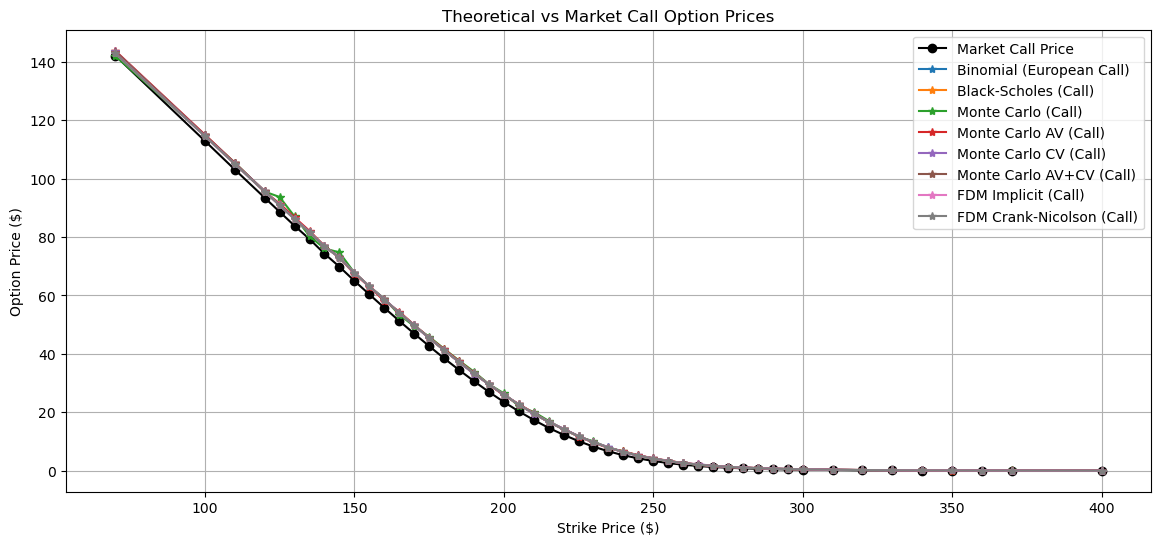

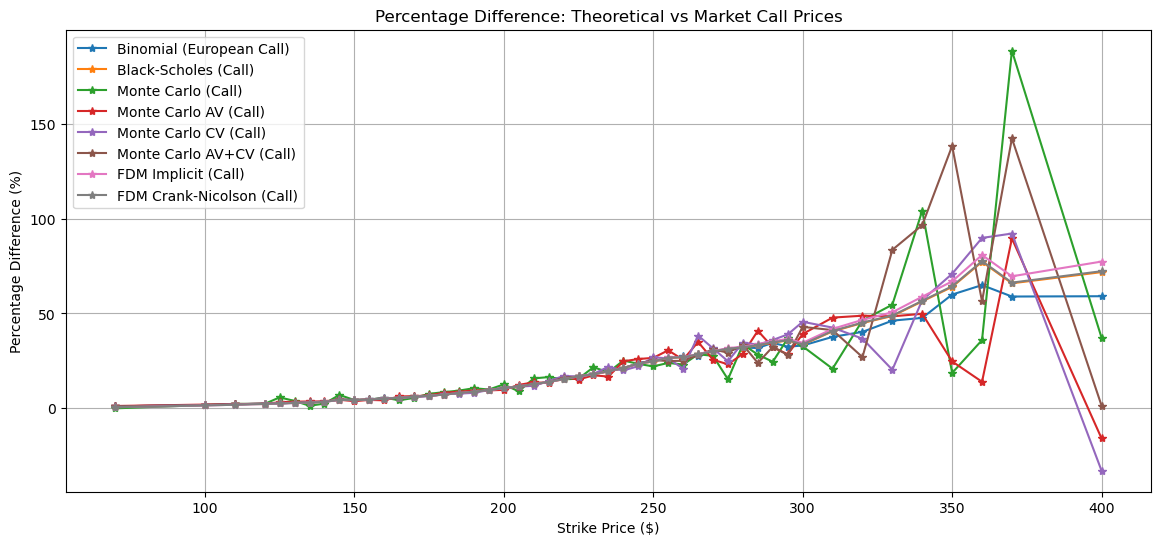

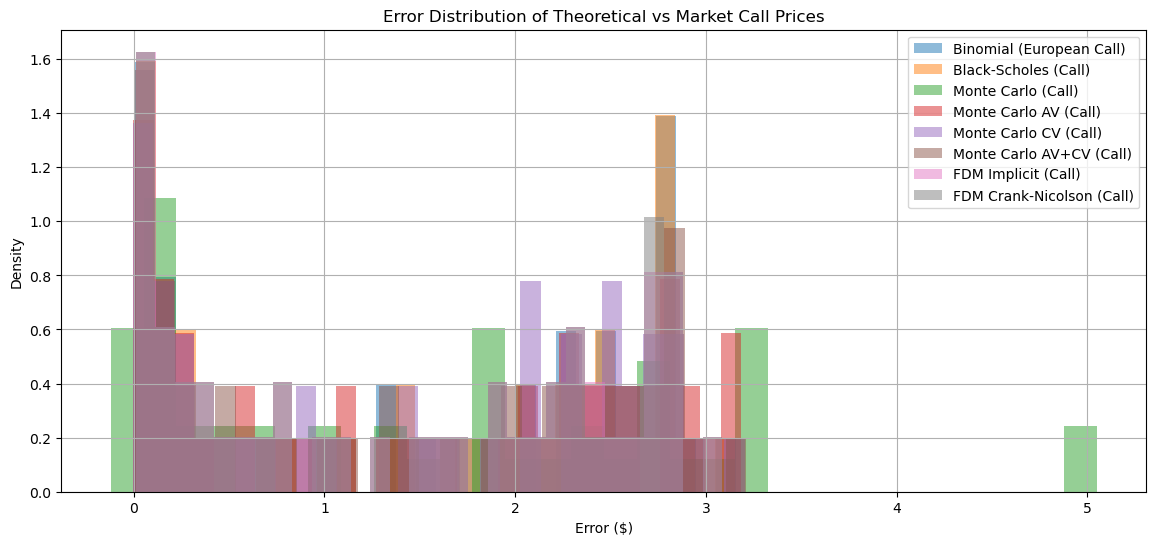


Comparison Results:
    Strike  Maturity  Market_Call  Market_Put  Binomial (European Call)_Price  \
0     70.0  0.432877      142.100       0.045                      143.469570   
1    100.0  0.432877      112.875       0.200                      114.755347   
2    110.0  0.432877      103.075       0.295                      105.143903   
3    120.0  0.432877       93.425       0.435                       95.659424   
4    125.0  0.432877       88.625       0.525                       90.914010   
5    130.0  0.432877       83.825       0.635                       86.182378   
6    135.0  0.432877       79.275       0.760                       81.708808   
7    140.0  0.432877       74.300       0.925                       76.818416   
8    145.0  0.432877       69.825       1.115                       72.983056   
9    150.0  0.432877       65.000       1.350                       67.788346   
10   155.0  0.432877       60.375       1.640                       63.152093   
11   16

In [24]:
def compare_with_market_data(df, r=0.05, Nsteps=1000, Nstock=10000, ds=1.0, dt=0.001, n=100):
    """Compare theoretical option prices with market data and perform statistical analysis."""
    results = []
    methods = [
        ('Binomial (European Call)', lambda S0, K, T, sigma: Binominal_tree(S0, K, T, r, n, sigma, 'Call','Europe')),
        ('Black-Scholes (Call)', lambda S0, K, T, sigma: BS(S0, K, T, r, sigma, 'call')),
        ('Monte Carlo (Call)', lambda S0, K, T, sigma: monte_carlo_option(S0, K, r, T, Nsteps, sigma, Nstock, 'call')[0]),
        ('Monte Carlo AV (Call)', lambda S0, K, T, sigma: monte_carlo_option_av(S0, K, r, sigma, T, Nsteps, Nstock, 'call')[0]),
        ('Monte Carlo CV (Call)', lambda S0, K, T, sigma: monte_carlo_option_cv(S0, K, r, sigma, T, Nsteps, Nstock, 'call')[0]),
        ('Monte Carlo AV+CV (Call)', lambda S0, K, T, sigma: monte_carlo_option_av_cv(S0, K, r, sigma, T, Nsteps,  Nstock, 'call')[0]),
        #('FDM Explicit (Call)', lambda S0, K, T, sigma: BS_FDM(S0, K, r, T, sigma, ds, dt, 'EXPLICIT', 'CALL')),
        ('FDM Implicit (Call)', lambda S0, K, T, sigma: BS_FDM(S0, K, r, T, sigma, ds, dt, 'IMPLICIT', 'CALL')),
        ('FDM Crank-Nicolson (Call)', lambda S0, K, T, sigma: BS_FDM(S0, K, r, T, sigma, ds, dt, 'CRANK', 'CALL'))
    ]

    for index, row in df.iterrows():
        S0 = row['Stock_Price']
        K = row['Strike']
        T = row['Maturity']
        sigma = row['Implied_Volatility']
        market_call = row['Call_Price']
        market_put = row.get('Put_Price', np.nan)

        row_results = {'Strike': K, 'Maturity': T, 'Market_Call': market_call, 'Market_Put': market_put}
        for name, func in methods:
            start_time = time.time()
            price = func(S0, K, T, sigma)
            elapsed_time = time.time() - start_time
            row_results[f'{name}_Price'] = price
            row_results[f'{name}_Diff'] = price - market_call
            row_results[f'{name}_%Diff'] = ((price - market_call) / market_call * 100) if market_call != 0 else np.nan
            row_results[f'{name}_Time'] = elapsed_time
        results.append(row_results)

    results_df = pd.DataFrame(results)

    # Statistical analysis
    stats_results = []
    for name, _ in methods:
        actual = results_df['Market_Call']
        predicted = results_df[f'{name}_Price']
        stats = statistical_analysis(actual, predicted, name)
        stats_results.append(stats)
    stats_df = pd.DataFrame(stats_results)

    # Plot comparison for Call prices
    plt.figure(figsize=(14, 6))
    plt.plot(results_df['Strike'], results_df['Market_Call'], 'o-', label='Market Call Price', color='black')
    for name, _ in methods:
        plt.plot(results_df['Strike'], results_df[f'{name}_Price'], '*-', label=name)
    plt.xlabel('Strike Price ($)')
    plt.ylabel('Option Price ($)')
    plt.title('Theoretical vs Market Call Option Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot percentage differences
    plt.figure(figsize=(14, 6))
    for name, _ in methods:
        plt.plot(results_df['Strike'], results_df[f'{name}_%Diff'], '*-', label=name)
    plt.xlabel('Strike Price ($)')
    plt.ylabel('Percentage Difference (%)')
    plt.title('Percentage Difference: Theoretical vs Market Call Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot error distribution
    plt.figure(figsize=(14, 6))
    for name, _ in methods:
        errors = results_df[f'{name}_Diff']
        plt.hist(errors, bins=30, alpha=0.5, label=name, density=True)
    plt.xlabel('Error ($)')
    plt.ylabel('Density')
    plt.title('Error Distribution of Theoretical vs Market Call Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_df, stats_df

# Main execution
# Parameters
symbol = "AAPL"
r = 0.05  # Risk-free rate (e.g., 5% annualized)
Nsteps = 1000
Nstock = 10000
ds = 1.0
dt = 0.001
n = 100

# Load option data from yfinance
print("\nLoading Option Market Data from Yahoo Finance...")
try:
    option_data = load_option_data(symbol)
    print("\nOption Market Data:")
    print(option_data)
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Compare theoretical prices with market data
print("\nComparison with Market Data:")
results_df, stats_df = compare_with_market_data(option_data, r, Nsteps, Nstock, ds, dt, n)
print("\nComparison Results:")
print(results_df)
print("\nStatistical Analysis:")
print(stats_df)


Loading Option Market Data from Yahoo Finance...


C:\Users\Phuc\AppData\Local\Temp\ipykernel_30912\1441011125.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['Stock_Price'] = S0
C:\Users\Phuc\AppData\Local\Temp\ipykernel_30912\1441011125.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['Maturity'] = T
C:\Users\Phuc\AppData\Local\Temp\ipykernel_30912\1441011125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the


Option Market Data:
    Strike  Call_Price  Implied_Volatility  Maturity  Stock_Price  Put_Price
0     70.0     142.100            0.911134  0.432877   211.160004      0.045
1    100.0     112.875            0.720950  0.432877   211.160004      0.200
2    110.0     103.075            0.656742  0.432877   211.160004      0.295
3    120.0      93.425            0.605595  0.432877   211.160004      0.435
4    125.0      88.625            0.581425  0.432877   211.160004      0.525
5    130.0      83.825            0.557011  0.432877   211.160004      0.635
6    135.0      79.275            0.544804  0.432877   211.160004      0.760
7    140.0      74.300            0.510991  0.432877   211.160004      0.925
8    145.0      69.825            0.526860  0.432877   211.160004      1.115
9    150.0      65.000            0.479986  0.432877   211.160004      1.350
10   155.0      60.375            0.456732  0.432877   211.160004      1.640
11   160.0      55.800            0.437872  0.432877   

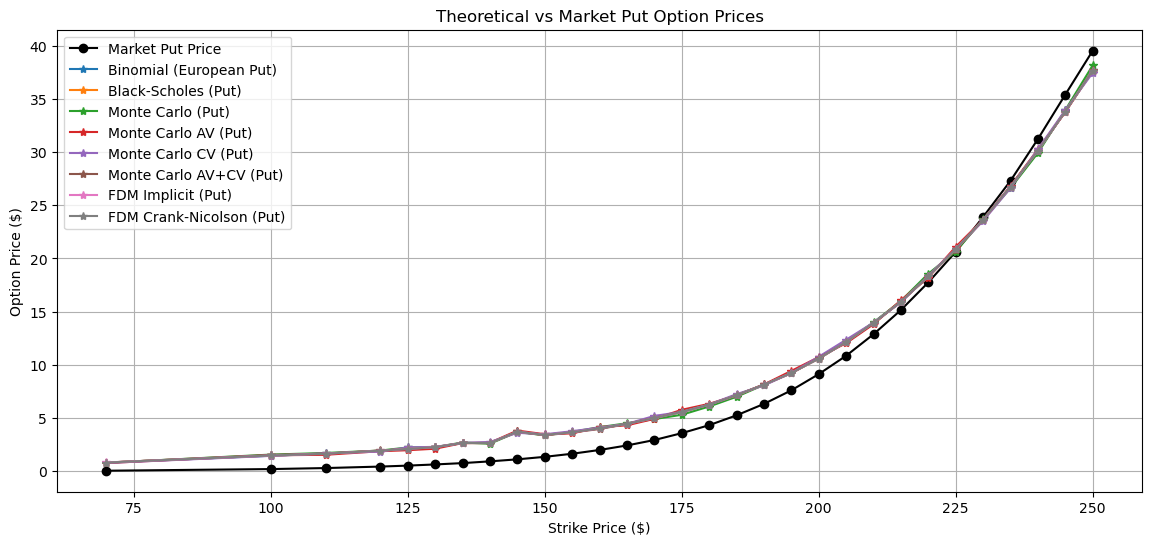

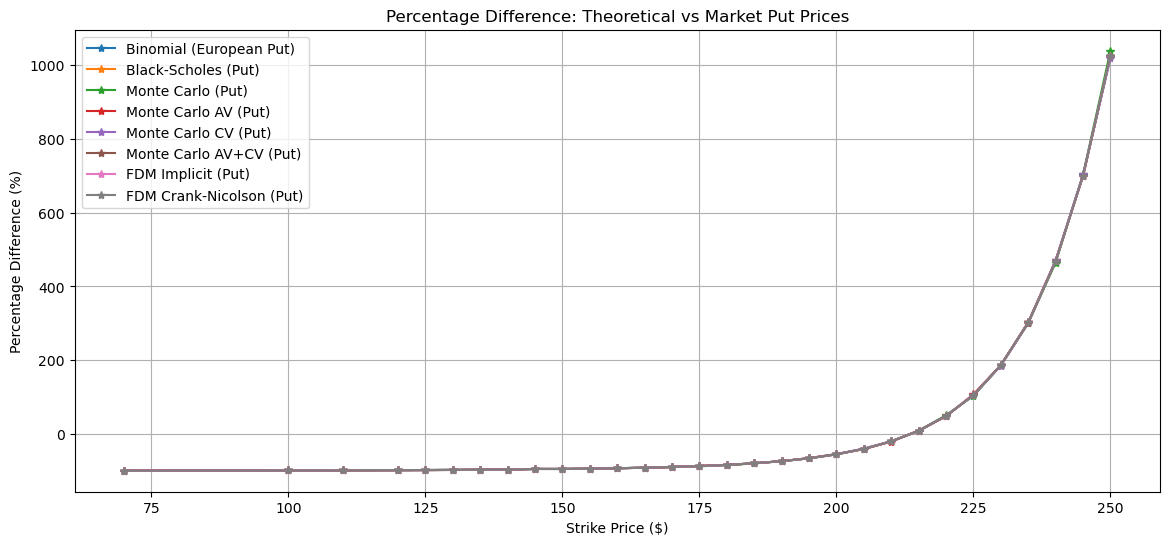

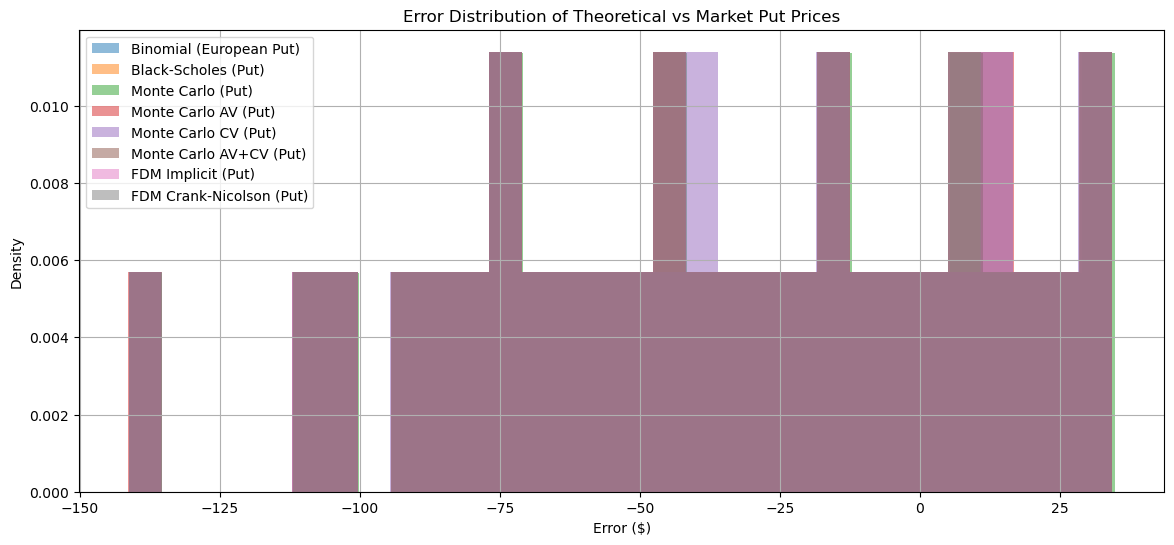


Comparison Results:
    Strike  Maturity  Market_Call  Market_Put  Binomial (European Put)_Price  \
0     70.0  0.432877      142.100       0.045                       0.810776   
1    100.0  0.432877      112.875       0.200                       1.454215   
2    110.0  0.432877      103.075       0.295                       1.628657   
3    120.0  0.432877       93.425       0.435                       1.930066   
4    125.0  0.432877       88.625       0.525                       2.077595   
5    130.0  0.432877       83.825       0.635                       2.238907   
6    135.0  0.432877       79.275       0.760                       2.658280   
7    140.0  0.432877       74.300       0.925                       2.660832   
8    145.0  0.432877       69.825       1.115                       3.718415   
9    150.0  0.432877       65.000       1.350                       3.416649   
10   155.0  0.432877       60.375       1.640                       3.673340   
11   160.0  0.43287

In [25]:
def compare_with_market_data(df, r=0.05, Nsteps=1000, Nstock=10000, ds=1.0, dt=0.001, n=100):
    """Compare theoretical option prices with market data and perform statistical analysis."""
    results = []
    methods = [
        ('Binomial (European Put)', lambda S0, K, T, sigma: Binominal_tree(S0, K, T, r, n, sigma, 'Put','Europe')),
        ('Black-Scholes (Put)', lambda S0, K, T, sigma: BS(S0, K, T, r, sigma, 'put')),
        ('Monte Carlo (Put)', lambda S0, K, T, sigma: monte_carlo_option(S0, K, r, T, Nsteps, sigma, Nstock, 'put')[0]),
        ('Monte Carlo AV (Put)', lambda S0, K, T, sigma: monte_carlo_option_av(S0, K, r, sigma, T, Nsteps, Nstock, 'put')[0]),
        ('Monte Carlo CV (Put)', lambda S0, K, T, sigma: monte_carlo_option_cv(S0, K, r, sigma, T, Nsteps, Nstock, 'put')[0]),
        ('Monte Carlo AV+CV (Put)', lambda S0, K, T, sigma: monte_carlo_option_av_cv(S0, K, r, sigma, T, Nsteps,  Nstock, 'put')[0]),
        #('FDM Explicit (Call)', lambda S0, K, T, sigma: BS_FDM(S0, K, r, T, sigma, ds, dt, 'EXPLICIT', 'CALL')),
        ('FDM Implicit (Put)', lambda S0, K, T, sigma: BS_FDM(S0, K, r, T, sigma, ds, dt, 'IMPLICIT', 'PUT')),
        ('FDM Crank-Nicolson (Put)', lambda S0, K, T, sigma: BS_FDM(S0, K, r, T, sigma, ds, dt, 'CRANK', 'PUT'))
    ]

    for index, row in df.iterrows():
        S0 = row['Stock_Price']
        K = row['Strike']
        T = row['Maturity']
        sigma = row['Implied_Volatility']
        market_call = row['Call_Price']
        market_put = row.get('Put_Price', np.nan)

        row_results = {'Strike': K, 'Maturity': T, 'Market_Call': market_call, 'Market_Put': market_put}
        for name, func in methods:
            start_time = time.time()
            price = func(S0, K, T, sigma)
            elapsed_time = time.time() - start_time
            row_results[f'{name}_Price'] = price
            row_results[f'{name}_Diff'] = price - market_call
            row_results[f'{name}_%Diff'] = ((price - market_call) / market_call * 100) if market_call != 0 else np.nan
            row_results[f'{name}_Time'] = elapsed_time
        results.append(row_results)

    results_df = pd.DataFrame(results)

    # Statistical analysis
    stats_results = []
    for name, _ in methods:
        actual = results_df['Market_Put']
        predicted = results_df[f'{name}_Price']
        stats = statistical_analysis(actual, predicted, name)
        stats_results.append(stats)
    stats_df = pd.DataFrame(stats_results)

    # Plot comparison for Call prices
    plt.figure(figsize=(14, 6))
    plt.plot(results_df['Strike'], results_df['Market_Put'], 'o-', label='Market Put Price', color='black')
    for name, _ in methods:
        plt.plot(results_df['Strike'], results_df[f'{name}_Price'], '*-', label=name)
    plt.xlabel('Strike Price ($)')
    plt.ylabel('Option Price ($)')
    plt.title('Theoretical vs Market Put Option Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot percentage differences
    plt.figure(figsize=(14, 6))
    for name, _ in methods:
        plt.plot(results_df['Strike'], results_df[f'{name}_%Diff'], '*-', label=name)
    plt.xlabel('Strike Price ($)')
    plt.ylabel('Percentage Difference (%)')
    plt.title('Percentage Difference: Theoretical vs Market Put Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot error distribution
    plt.figure(figsize=(14, 6))
    for name, _ in methods:
        errors = results_df[f'{name}_Diff']
        plt.hist(errors, bins=30, alpha=0.5, label=name, density=True)
    plt.xlabel('Error ($)')
    plt.ylabel('Density')
    plt.title('Error Distribution of Theoretical vs Market Put Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_df, stats_df

# Main execution
# Parameters
symbol = "AAPL"
r = 0.05  # Risk-free rate (e.g., 5% annualized)
Nsteps = 1000
Nstock = 10000
ds = 1.0
dt = 0.001
n = 100

# Load option data from yfinance
print("\nLoading Option Market Data from Yahoo Finance...")
try:
    option_data = load_option_data(symbol).dropna()
    print("\nOption Market Data:")
    print(option_data)
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Compare theoretical prices with market data
print("\nComparison with Market Data:")
results_df, stats_df = compare_with_market_data(option_data, r, Nsteps, Nstock, ds, dt, n)
print("\nComparison Results:")
print(results_df)
print("\nStatistical Analysis:")
print(stats_df)